In [1]:
import os, sys

codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from plotting import plot_utils, load_fits
from utils import roi_utils, default_paths
from analyze_fits import analyze_gabor_params

import copy

from feature_extraction import gabor_feature_extractor


/home/mmhender/imstat_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load fit results

In [2]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type = 'gabor_solo_ridge_12ori_8sf'
out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, \
                                  verbose=False) for ss in subjects]
fitting_type2 = 'gabor_solo_ridge_12ori_8sf_permutation_test'
out_shuff = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type2, n_from_end=0, \
                                  verbose=False)  for ss in subjects]

# create ROIs
roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = len(roi_names)

# make a list of voxels per subject
n_vox_each_subj = [out[si]['best_params'][0].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones((n_vox_each_subj[si],),dtype=int) \
                               for si in range(n_subjects)], axis=0)

#### Process results of permutation test, compute p-values

In [3]:
from utils import stats_utils
from plotting import summary_plots

p_voxels_orig = [[] for si in range(n_subjects)]

for si in range(n_subjects):

    # stats for single voxels
    r2_real_orig = out[si]['val_r2']
    r2_shuff_orig = out_shuff[si]['val_r2']

    # for how many of the shuffle iterations did shuffle-R2 exceed real-R2?
    p_orig = np.mean(r2_real_orig[:,0,None]<=r2_shuff_orig[:,0,:], axis=1)
    _,pvals_fdr_orig = stats_utils.fdr_keepshape(p_orig, alpha=0.01, \
                                                   method='poscorr')
    p_voxels_orig[si] = pvals_fdr_orig
    
# thresholding voxels based on the permutation test
p = np.concatenate(p_voxels_orig, axis=0)
abv_thresh = p<0.01


#### Get info about the Gabor feature space

In [4]:
n_sf=8; n_ori=12;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

screen_eccen_deg=8.4
sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)

ori_deg = _gabor_ext_complex.feature_table['Orientation: degrees']
ori_unique, orient_inds = np.unique(ori_deg, return_inverse=True)


#### Do some analyses on the orientation/frequency sensitivity profiles - find their peaks

In [5]:
feature_corr = np.concatenate([out[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr.shape[0]
allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')

# first averaging over either orient or SF - then analyze "tuning curves" for other dimension.
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)


n_ori_peaks, top_orients = analyze_gabor_params.analyze_orient_peaks(est_tuning_curves=mean_orient_corr, \
                                                                 abv_thresh = abv_thresh, peak_thresh=0.50,\
                                                                 ori_unique = ori_unique);

n_freq_peaks, top_freqs = analyze_gabor_params.analyze_freq_peaks(est_tuning_curves=mean_sf_corr, \
                                                                 abv_thresh = abv_thresh, peak_thresh=0.50,\
                                                                 sf_unique = sf_unique);

In [6]:
n_ori_peaks.shape

(150842,)

#### compute summary statistics for each ROI, each subject

how many voxels with each num peaks per roi, per subject?

In [7]:
n_ori_peaks_vals = np.arange(0,6)
roi_counts_n_ori_peaks = np.zeros((n_subjects, n_rois,len(n_ori_peaks_vals)),dtype=int)

for si in range(n_subjects):
    for ri in range(n_rois):
        inds = roi_def.get_indices(ri) & (subject_inds==si) & abv_thresh
        for pi, pp in enumerate(n_ori_peaks_vals):
            roi_counts_n_ori_peaks[si,ri,pi] = np.sum(n_ori_peaks[inds]==pp)

        assert(np.sum(roi_counts_n_ori_peaks[si,ri,:])==np.sum(inds))


#### make a bar plot of the number of peaks

['has 0 peak', 'has 1 peak', 'has 2 peak', 'has >=3 peaks']


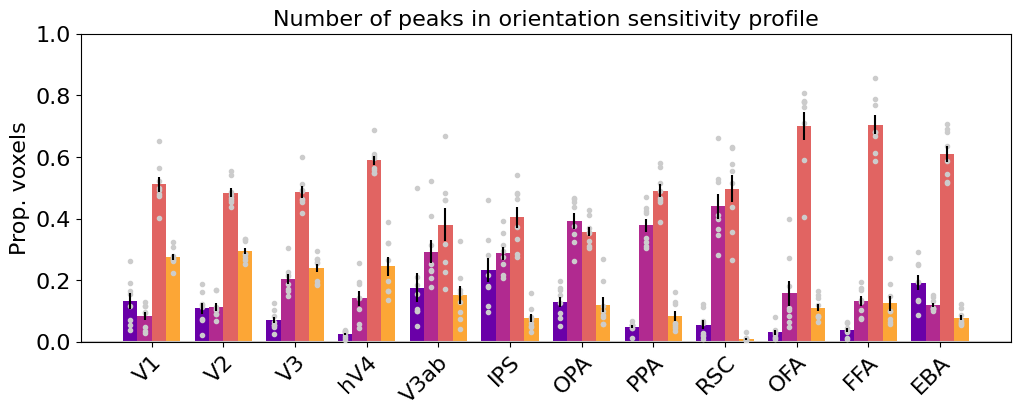

In [8]:
# combining anything >=3 into a single bar here

vals = copy.deepcopy(roi_counts_n_ori_peaks)
vals[:,:,3] = np.sum(vals[:,:,3:], axis=2)
vals = vals[:,:,0:4]

vals = vals/np.sum(vals, axis=2, keepdims=True) # convert to a proportion of total

meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

labels = ['has %d peak'%pp for pp in n_ori_peaks_vals[0:4]]
labels[3] = 'has >=3 peaks'

print(labels)

colors = cm.plasma(np.linspace(0,1,6))[1:6,:]

plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(16)
fh = plot_utils.plot_multi_bars(mean_data=meanvals, err_data=semvals, \
                                space=0.1, \
                                point_data = vals, \
                xticklabels=roi_names, ylabel='Prop. voxels', \
                ylim=[0,1.0], title='Number of peaks in orientation sensitivity profile', \
                horizontal_line_pos=0,\
                legend_labels=labels, \
                legend_overlaid=False, legend_separate=False, \
                fig_size=(12,4), \
                colors=colors)

fn2save = os.path.join(default_paths.fig_path, 'Num_orient_peaks.pdf')
plt.savefig(fn2save)

#### Do some more analysis on the multi-peaked voxels

Separate them into groups w same peak locations

In [9]:
which_bimodal_group, top_bimodal_pairs, bimodal_pair_labels = \
        analyze_gabor_params.group_bimodal_voxels(n_ori_peaks, top_orients, n_groups_use=3)

which_trimodal_group, top_trimodal_pairs, trimodal_pair_labels = \
        analyze_gabor_params.group_trimodal_voxels(n_ori_peaks, top_orients, n_groups_use=3)

#### compute bimodal voxels summary statistics for each roi/subject

In [10]:
n_groups=4;
roi_counts_bimodal = np.zeros((n_subjects, n_rois, n_groups),dtype=int)
for si in range(n_subjects):
    for ri in range(n_rois):
        inds = roi_def.get_indices(ri) & (subject_inds==si) & abv_thresh & (n_ori_peaks==2)
        for pp in range(n_groups):
            roi_counts_bimodal[si,ri,pp] = np.sum(which_bimodal_group[inds]==pp)
            
        assert(np.sum(roi_counts_bimodal[si,ri,:])==np.sum(inds))


#### Make a barplot

['peaks at 45/135 deg', 'peaks at 30/150 deg', 'peaks at 0/90 deg', 'Some other pair of orients']


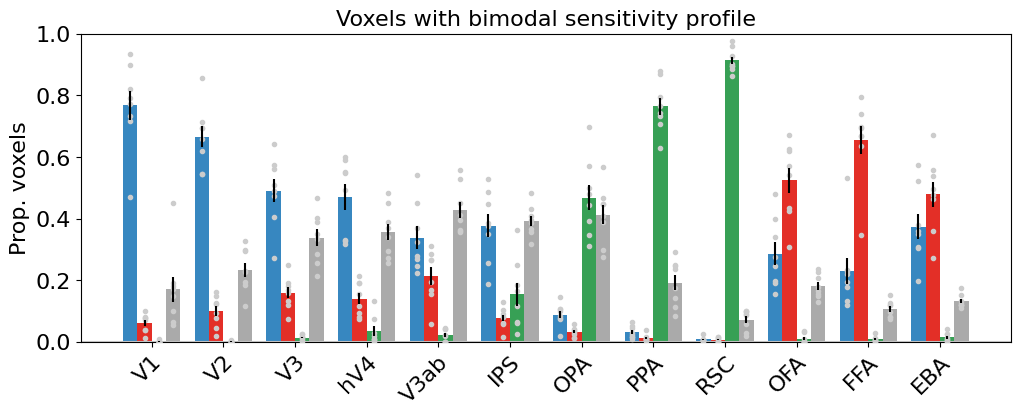

In [11]:
colors = np.concatenate([cm.Blues(np.linspace(0,1,4))[2:3,:],\
                         cm.Reds(np.linspace(0,1,4))[2:3,:],\
                         cm.Greens(np.linspace(0,1,4))[2:3,:],\
                         # cm.Purples(np.linspace(0,1,4))[2:3,:],\
                         cm.gray(np.linspace(0,1,4))[2:3,:]], axis=0)

vals = roi_counts_bimodal
vals = roi_counts_bimodal/np.sum(roi_counts_bimodal, axis=2, keepdims=True)

meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

ylim = [0,1]
# ylim=[]
print(bimodal_pair_labels)

fh = plot_utils.plot_multi_bars(mean_data=meanvals, err_data=semvals, \
                                space=0.1, \
                                point_data=vals,\
                                xticklabels=roi_names, ylabel='Prop. voxels', \
                ylim=ylim, title='Voxels with bimodal sensitivity profile', horizontal_line_pos=0,\
                legend_labels=bimodal_pair_labels, \
                legend_overlaid=False, legend_separate=False, \
                fig_size=(12,4), \
                colors=colors)

fn2save = os.path.join(default_paths.fig_path, 'Bimodal_groups.pdf')
plt.savefig(fn2save)

#### Same thing for frequency

here there are mostly uni-modal voxels

In [12]:
n_freq_peaks_vals = np.arange(0,4)
roi_counts_n_freq_peaks = np.zeros((n_subjects, n_rois,len(n_freq_peaks_vals)),dtype=int)

for si in range(n_subjects):
    for ri in range(n_rois):
        inds = roi_def.get_indices(ri) & (subject_inds==si) & abv_thresh
        for pi, pp in enumerate(n_freq_peaks_vals):
            roi_counts_n_freq_peaks[si,ri,pi] = np.sum(n_freq_peaks[inds]==pp)

        assert(np.sum(roi_counts_n_freq_peaks[si,ri,:])==np.sum(inds))


#### make a bar plot of the number of peaks

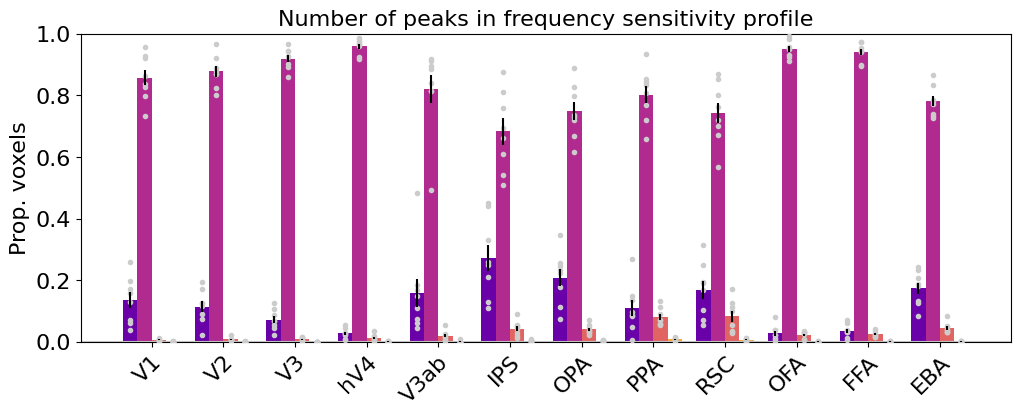

In [13]:
vals = roi_counts_n_freq_peaks

vals = vals/np.sum(vals, axis=2, keepdims=True) # convert to a proportion of total

meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

labels = ['has %d peak'%pp for pp in n_freq_peaks_vals]

colors = cm.plasma(np.linspace(0,1,6))[1:6,:]

plot_utils.set_all_font_sizes(16)
fh = plot_utils.plot_multi_bars(mean_data=meanvals, err_data=semvals, \
                                space=0.1, \
                                point_data=vals,\
                xticklabels=roi_names, ylabel='Prop. voxels', \
                ylim=[0,1], title='Number of peaks in frequency sensitivity profile', \
                horizontal_line_pos=0,\
                legend_labels=labels, \
                legend_overlaid=False, legend_separate=False, \
                fig_size=(12,4), \
                colors=colors)

fn2save = os.path.join(default_paths.fig_path, 'Num_spatfreq_peaks.pdf')
plt.savefig(fn2save)

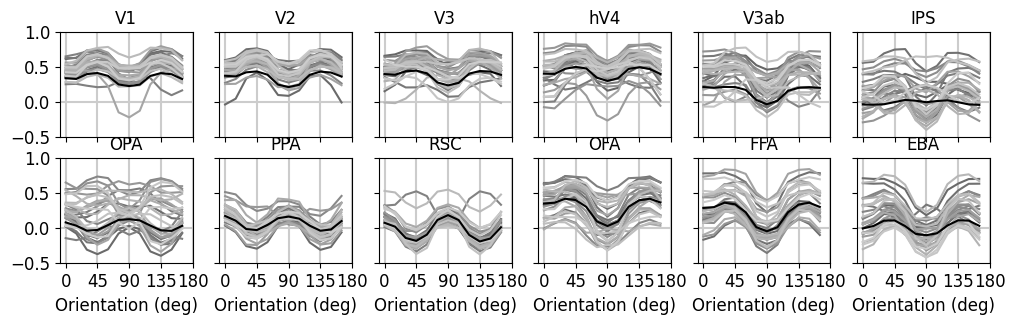

In [14]:
plot_utils.set_all_font_sizes(12)
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(12,3))

# rois2plot = [0,3,7,8,10,11]
rois2plot = np.arange(n_rois)

npy = int(len(rois2plot)/2)
npx = 2;

# npy = int(len(rois2plot))
# npx = 1;

# plot_inds = []
# for rr in range(n_rois):
#     plot_inds += [rr+1]
#     plot_inds += [rr+n_rois+1]
    
n_peaks = 2
n_vox_plot = 30

rndseed = 234355
np.random.seed(rndseed)

# ylims = [-1.0, 1.0]
# yticks = [-1.0, -0.5, 0, 0.5, 1.0]
ylims = [-0.5, 1.0]
yticks = [-0.5, 0, 0.5, 1.0]

pi=0

for ri, rr in enumerate(rois2plot):
# for rr in range(n_rois):
    
    pi+=1
    plt.subplot(npx,npy,pi)
    
    # identify voxels in this ROI, having the specified number of peaks
    inds_this_roi_npeaks = abv_thresh & roi_def.get_indices(rr) & (n_ori_peaks==n_peaks)
    tuning_curves_npeaks = mean_orient_corr[inds_this_roi_npeaks,:]
    nv = tuning_curves_npeaks.shape[0]
    color_offsets = np.linspace(-0.2, 0.2, n_vox_plot)
    for xx, ii in enumerate(np.random.choice(np.arange(nv), n_vox_plot)):  
        plt.plot(ori_unique, tuning_curves_npeaks[ii,:], '-', color=[0.6, 0.6, 0.6]+color_offsets[xx])

    # also want to compute the mean over all voxels in the ROI (regardless of npeaks)
    inds_this_roi = abv_thresh & roi_def.get_indices(rr)
    tuning_curves_all = mean_orient_corr[inds_this_roi,:]
    meanvals = np.mean(tuning_curves_all, axis=0)
    plt.plot(ori_unique,  meanvals, '-',color='k')
    
    
    plt.axhline(0, color=[0.8, 0.8, 0.8],zorder=-10)
    plt.ylim(ylims)
    
    if np.mod(pi,npy)==1:
        # plt.ylabel('corr coef')
        plt.yticks(yticks)
    else:
        plt.yticks(yticks, labels=[])

    if ri>=npy:
        plt.xlabel('Orientation (deg)')
        plt.xticks(np.arange(0,181,45))
    else:
        plt.xticks(np.arange(0,181,45), labels=[])

    for ii in np.arange(0,181,45):
        plt.axvline(ii,color=[0.8, 0.8, 0.8],zorder=-10)

    plt.title('%s'%(roi_names[rr]))
    
fn2save = os.path.join(default_paths.fig_path, 'Example_bimodal_voxels.pdf')
plt.savefig(fn2save)